In [1]:
import time
import re
import os
import math
import numpy as np
from matplotlib import pyplot as plt
import requests
import collections
import pickle
import copy, random
np.random.seed(1234)
import nltk as nl
nl.download('punkt')

from itertools import zip_longest

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Reshape, BatchNormalization, Dense, Dropout, concatenate,       # General
    Embedding, LSTM, Dense, GRU, Bidirectional,                              # RNN
    MaxPooling1D, Conv1D, Flatten
)
from tensorflow.keras.activations import elu, relu, softmax, sigmoid
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
2.2.0


In [2]:
def get_hyp_lm_tercets(tercets):
    new_tercets = []
    for tercet in tercets:
        new_tercets.append([])
        for verse in tercet:
            new_tercets[-1].append([])
            for hyp_w in verse:
                new_tercets[-1][-1].extend(hyp_w)
                new_tercets[-1][-1].append('<SEP>')
            new_tercets[-1][-1] = new_tercets[-1][-1][:-1]

    return new_tercets

def is_vowel(c):
    return c in 'aeiouAEIOUàìíèéùúüòï'

def unsplittable_cons():
    u_cons = []
    for c1 in ('b', 'c', 'd', 'f', 'g', 'p', 't', 'v'):
        for c2 in ('l', 'r'):
            u_cons.append(c1 + c2)

    others = ['gn', 'gh', 'ch']
    u_cons.extend(others)
    return u_cons


def are_cons_to_split(c1, c2):
    to_split = ('cq', 'cn', 'lm', 'rc', 'bd', 'mb', 'mn', 'ld', 'ng', 'nd', 'tm', 'nv', 'nc', 'ft', 'nf', 'gm', 'fm', 'rv', 'fp')
    return (c1 + c2) in to_split or (not is_vowel(c1) and (c1 == c2)) or ((c1 + c2) not in unsplittable_cons()) and (
        (not is_vowel(c1)) and (not is_vowel(c2)) and c1 != 's')


def is_diphthong(c1, c2):
    return (c1 + c2) in ('ia', 'ie', 'io', 'iu', 'ua', 'ue', 'uo', 'ui', 'ai', 'ei', 'oi', 'ui', 'au', 'eu', 'ïe', 'iú', 'iù')


def is_triphthong(c1, c2, c3):
    return (c1 + c2 + c3) in ('iai', 'iei', 'uoi', 'uai', 'uei', 'iuo')


def is_toned_vowel(c):
    return c in 'àìèéùòï'

def has_vowels(sy):
    for c in sy:
        if is_vowel(c):
            return True
    return False


def hyphenation(word):
    """
    Split word in syllables
    :param word: input string
    :return: a list containing syllables of the word
    """
    if not word or word == '':
        return []
    # elif len(word) == 3 and (is_vowel(word[1]) and is_vowel(word[2]) and not is_toned_vowel(word[2]) and (
    #     not is_diphthong(word[1], word[2]) or (word[1] == 'i'))):
    elif len(word) == 3 and (is_vowel(word[1]) and is_vowel(word[2]) and not is_toned_vowel(word[2]) and (
        not is_diphthong(word[1], word[2]))):
        return [word[:2]] + [word[2]]
    elif len(word) == 3 and is_vowel(word[0]) and not is_vowel(word[1]) and is_vowel(word[2]):
        return [word[:2]] + [word[2]]
    elif len(word) == 3:
        return [word]

    syllables = []
    is_done = False
    count = 0
    while not is_done and count <= len(word) - 1:
        syllables.append('')
        c = word[count]
        while not is_vowel(c) and count < len(word) - 1:
            syllables[-1] = syllables[-1] + c
            count += 1
            c = word[count]

        syllables[-1] = syllables[-1] + word[count]

        if count == len(word) - 1:
            is_done = True
        else:
            count += 1

            if count < len(word) and not is_vowel(word[count]):
                if count == len(word) - 1:
                    syllables[-1] += word[count]
                    count += 1
                elif count + 1 < len(word) and are_cons_to_split(word[count], word[count + 1]):
                    syllables[-1] += word[count]
                    count += 1
                elif count + 2 < len(word) and not is_vowel(word[count + 1]) and not is_vowel(word[count + 2]) and word[
                    count] != 's':
                    syllables[-1] += word[count]
                    count += 1
            elif count < len(word):
                if count + 1 < len(word) and is_triphthong(word[count - 1], word[count], word[count + 1]):
                    syllables[-1] += word[count] + word[count + 1]
                    count += 2
                elif is_diphthong(word[count - 1], word[count]):
                    syllables[-1] += word[count]
                    count += 1

                if count + 1 < len(word) and are_cons_to_split(word[count], word[count + 1]):
                    syllables[-1] += word[count]
                    count += 1

            else:
                is_done = True

    if not has_vowels(syllables[-1]) and len(syllables) > 1:
        syllables[-2] = syllables[-2] + syllables[-1]
        syllables = syllables[:-1]

    return syllables



def get_dc_hyphenation(canti):
    hyp_canti, hyp_tokens = [], []
    for canto in canti:
        hyp_canti.append([])
        for verso in canto:
            syllables = seq_hyphentation(verso)
            hyp_canti[-1].append(syllables)
            for syllable in syllables:
                hyp_tokens.extend(syllable)

    return hyp_canti, hyp_tokens


def seq_hyphentation(words):
    """
    Converts words in a list of strings into lists of syllables
    :param words: a list of words (strings)
    :return: a list of lists containing word syllables
    """
    return [hyphenation(w) for w in words]


def get_dc_cantos(filename, encoding=None):
    # raw_data = read_words(filename=filename)
    cantos, words, raw = [], [], []
    with open(filename, "r", encoding=encoding) as f:
        for line in f:
            sentence = line.strip()
            sentence = str.replace(sentence, "\.", " \. ")
            sentence = str.replace(sentence, "[", '')
            sentence = str.replace(sentence, "]", '')
            sentence = str.replace(sentence, "-", '')
            sentence = str.replace(sentence, ";", " ; ")
            sentence = str.replace(sentence, ",", " , ")
            # sentence = str.replace(sentence, " \'", '')
            sentence = str.replace(sentence, "\'", ' \' ')
            if len(sentence) > 1:
                # sentence = sentence.translate(string.punctuation)
                tokenized_sentence = nl.word_tokenize(sentence)
                # tokenized_sentence = sentence.split()
                tokenized_sentence = [w.lower() for w in tokenized_sentence if len(w) > 0]
                tokenized_sentence = [w for w in tokenized_sentence if "," not in w]
                tokenized_sentence = [w for w in tokenized_sentence if "." not in w]
                tokenized_sentence = [w for w in tokenized_sentence if ":" not in w]
                tokenized_sentence = [w for w in tokenized_sentence if ";" not in w]
                tokenized_sentence = [w for w in tokenized_sentence if "«" not in w]
                tokenized_sentence = [w for w in tokenized_sentence if "»" not in w]
                # ts = []
                ts = tokenized_sentence
                # [ts.extend(re.split("(\')", e)) for e in tokenized_sentence]
                tokenized_sentence = [w for w in ts if len(w) > 0]

                if len(tokenized_sentence) == 2:
                    cantos.append([])
                    raw.append([])
                elif len(tokenized_sentence) > 2:
                    raw[-1].append(sentence)
                    cantos[-1].append(tokenized_sentence)
                    words.extend(tokenized_sentence)

    return cantos, words, raw


def create_tercets(cantos):
    tercets = []
    for i,canto in enumerate(cantos):
        for v,verse in enumerate(canto):
            if v%3 == 0:
                tercets.append([])

            tercets[-1].append(verse)
        tercets = tercets[:-1]  # removes the last malformed tercets (only 2 verses)

    return tercets

def pad_list(l, pad_token, max_l_size, keep_lasts=False, pad_right=True):
    """
    Adds a padding token to a list
    inputs:
    :param l: input list to pad.
    :param pad_token: value to add as padding.
    :param max_l_size: length of the new padded list to return,
    it truncates lists longer that 'max_l_size' without adding
    padding values.
    :param keep_lasts: If True, preserves the max_l_size last elements
    of a sequence (by keeping the same order).  E.g.:
    if keep_lasts is True and max_l_size=3 [1,2,3,4] becomes [2,3,4].


    :return: the list padded or truncated.
    """
    to_pad = []
    max_l = min(max_l_size, len(l))  # maximum len
    l_init = len(l) - max_l if len(l) > max_l and keep_lasts else 0  # initial position where to sample from the list
    l_end = len(l) if len(l) > max_l and keep_lasts else max_l
    for i in range(l_init, l_end):
        to_pad.append(l[i])

    # for j in range(len(l), max_l_size):
    #     to_pad.append(pad_token)
    pad_tokens = [pad_token] * (max_l_size-len(l))
    padded_l = to_pad + pad_tokens if pad_right else pad_tokens + to_pad

    return padded_l


def save_data(data, file):
    with open(file, 'wb') as output:
        pickle.dump(data, output, pickle.HIGHEST_PROTOCOL)

def load_data(file):
    with open(file, 'rb') as obj:
        return pickle.load(obj)

def print_and_write(file, s):
    print(s)
    file.write(s)


class Vocabulary(object):
    def __init__(self, vocab_size=None):
        self.dictionary = dict()
        self.rev_dictionary = dict()
        self.count = []
        self.special_tokens = []
        self.vocab_size = vocab_size

    def build_vocabulary_from_counts(self, count, special_tokens=[]):
        """
        Sets all the attributes of the Vocabulary object.
        :param count: a list of lists as follows: [['token', number_of_occurrences],...]
        :param special_tokens: a list of strings. E.g. ['<EOS>', '<PAD>',...]
        :return: None
        """

        dictionary = dict()
        for word, _ in count:
            dictionary[word] = len(dictionary)

        # adding eventual special tokens to the dictionary (e.g. <EOS>,<PAD> etc..)
        d = len(dictionary)
        for i, token in enumerate(special_tokens):
            dictionary[token] = d + i

        self.count = count
        self.dictionary = dictionary
        self.rev_dictionary = dict(zip(self.dictionary.values(), self.dictionary.keys()))
        self.special_tokens = special_tokens
        self.vocab_size = len(dictionary)

    def build_vocabulary_from_tokens(self, tokens, vocabulary_size=None, special_tokens=[]):
        """
        Given a list of tokens, it sets the Vocabulary object attributes by constructing
        a dictionary mapping each token to a unique id.
        :param tokens: a list of strings.
         E.g. ["the", "cat", "is", ... ".", "the", "house" ,"is" ...].
         NB: Here you should put all your token instances of the corpus.
        :param vocabulary_size: The number of elements of your vocabulary. If there are more
        than 'vocabulary_size' elements on tokens, it considers only the 'vocabulary_size'
        most frequent ones.
        :param special_tokens: Optional. A list of strings. Useful to add special tokens in vocabulary.
        If you don't have any, keep it empty.
        :return: None
        """

        vocabulary_size = vocabulary_size if vocabulary_size is not None else self.vocab_size
        vocabulary_size = vocabulary_size - (len(special_tokens) + 1) if vocabulary_size else None
        # counts occurrences of each token
        count = [['<UNK>', -1]]
        count.extend(collections.Counter(tokens).most_common(vocabulary_size))  # takes only the most frequent ones, if size is None takes them all
        self.build_vocabulary_from_counts(count, special_tokens)  # actually build the vocabulary
        self._set_unk_count(tokens)  # set the number of OOV instances

    @staticmethod
    def merge_vocabulary(vocab0, vocab1, vocabulary_size=-1):
        """
        Merge two Vocabulary objects into a new one.
        :param vocab0: first Vocabulary object
        :param vocab1: second Vocabulary object
        :param vocabulary_size: parameter to decide the merged vocabulary size.
        With default value -1, all the words of both vocabularies are preserved.
        When set to 0, the size of the vocabulary is set to the size of vocab0,
        when set to 1 it is kept the size of vocab1.
        :return: a new vocabulary
        """
        # get size of the new vocabulary
        vocab_size = vocab0.vocab_size + vocab1.vocab_size if vocabulary_size == -1 else vocabulary_size
        merged_special_tokens = list(set(vocab0.special_tokens) | set(vocab1.special_tokens))

        # merge the counts from the two vocabularies and then selects the most_common tokens
        merged_counts = collections.Counter(dict(vocab0.count)) + collections.Counter(dict(vocab1.count))
        merged_counts = merged_counts.most_common(vocab_size)
        count = [['<UNK>', -1]]
        count.extend(merged_counts)

        # create the new vocabulary
        merged_vocab = Vocabulary(vocab_size)
        merged_vocab.build_vocabulary_from_counts(count, merged_special_tokens)
        return merged_vocab

    @staticmethod
    def merge_vocabularies(vocab_list, vocab_size=None):
        """
        Join a list of vocabularies into a new one.
        :param vocab_list: a list of Vocabulary objects
        :param vocab_size: the maximum size of the merged vocabulary.
        :return: a vocabulary merging them all.
        """
        vocab_size = vocab_size if vocab_size else sum([v.vocab_size for v in vocab_list])
        merged_vocab = Vocabulary(vocab_size)
        for voc in vocab_list:
            merged_vocab = Vocabulary.merge_vocabulary(merged_vocab, voc, vocab_size)
        return merged_vocab

    def string2id(self, dataset):
        """
        Converts a dataset of strings into a dataset of ids according to the object dictionary.
        :param dataset: any string-based dataset with any nested lists.
        :return: a new dataset, with the same shape of dataset, where each string is mapped into its
        corresponding id associated in the dictionary (0 for unknown tokens).
        """

        def _recursive_call(items):
            new_items = []
            for item in items:
                if isinstance(item, str) or isinstance(item, int) or isinstance(item, float):
                    new_items.append(self.word2id(item))
                else:
                    new_items.append(_recursive_call(item))
            return new_items

        return _recursive_call(dataset)

    def id2string(self, dataset):
        """
        Converts a dataset of integer ids into a dataset of string according to the reverse dictionary.
        :param dataset: any int-based dataset with any nested lists. Allowed types are int, np.int32, np.int64.
        :return: a new dataset, with the same shape of dataset, where each token is mapped into its
        corresponding string associated in the reverse dictionary.
        """
        def _recursive_call(items):
            new_items = []
            for item in items:
                if isinstance(item, int) or isinstance(item, np.int) or isinstance(item, np.int32) or isinstance(item, np.int64):
                    new_items.append(self.id2word(item))
                else:
                    new_items.append(_recursive_call(item))
            return new_items

        return _recursive_call(dataset)

    def word2id(self, item):
        """
        Maps a string token to its corresponding id.
        :param item: a string.
        :return: If the token belongs to the vocabulary, it returns an integer id > 0, otherwise
        it returns the value associated to the unknown symbol, that is typically 0.
        """
        return self.dictionary[item] if item in self.dictionary else self.dictionary['<UNK>']

    def id2word(self, token_id):
        """
        Maps an integer token to its corresponding string.
        :param token_id: an integer.
        :return: If the id belongs to the vocabulary, it returns the string
        associated to it, otherwise it returns the string associated
        to the unknown symbol, that is '<UNK>'.
        """

        return self.rev_dictionary[token_id] if token_id in self.rev_dictionary else self.rev_dictionary[self.dictionary['<UNK>']]

    def get_unk_count(self):
        return self.count[0][1]

    def _set_unk_count(self, tokens):
        """
        Sets the number of OOV instances in the tokens provided
        :param tokens: a list of tokens
        :return: None
        """
        data = list()
        unk_count = 0
        for word in tokens:
            if word in self.dictionary:
                index = self.dictionary[word]
            else:
                index = 0  # dictionary['<UNK>']
                unk_count += 1
            data.append(index)
        self.count[0][1] = unk_count

    def add_element(self, name, is_special_token=False):
        if name not in self.dictionary:
            self.vocab_size += 1
            self.dictionary[name] = self.vocab_size
            self.rev_dictionary[self.vocab_size] = name

            if is_special_token:
                self.special_tokens = list(self.special_tokens)
                self.special_tokens.append(name)

            self.count.append([name, 1])

    def set_vocabulary(self, dictionary, rev_dictionary, special_tokens, vocab_size):
        self.dictionary = dictionary,
        self.rev_dictionary = rev_dictionary
        self.special_tokens = special_tokens
        self.vocab_size = vocab_size

    @staticmethod
    def load_vocabulary(filename):
        return load_data(filename)

    def save_vocabulary(self, filename):
        save_data(self, filename)







class SyLMDataset(object):
    def __init__(self, config, sy_vocab=None):
        self.config = config
        self.vocabulary = sy_vocab

        self.raw_train_x = []
        self.raw_val_x = []
        self.raw_test_x = []
        self.raw_x = []

        self.train_x, self.train_y = [], []
        self.val_x, self.val_y = [], []
        self.test_x, self.test_y = [], []
        self.x, self.y = [], []

    def initialize(self, sess):
        pass

    def load(self, sources):
        """
        Extract raw texts form sources and gather them all together.
        :param sources: a string or an iterable of strings containing the file(s)
        to process in order to build the dataset.
        :return: a list of raw strings.
        """
        return NotImplementedError

    def build(self, sources, split_size=0.8):
        """
        :param sources: a string or an iterable of strings containing the file(s)
        to process in order to build the dataset.
        :param split_size: the size to split the dataset, set >=1.0 to not split.
        """

        raw_x = self.load(sources)
        # raw_x = self.tokenize([self.preprocess(ex) for ex in raw_x])  # fixme
        # splitting data
        self.raw_x = raw_x
        if split_size < 1.0:
            self.raw_train_x, self.raw_test_x = self.split(self.raw_x, train_size=split_size)
            self.raw_train_x, self.raw_val_x = self.split(self.raw_train_x, train_size=split_size)
        else:
            self.raw_train_x = self.raw_x

        if self.vocabulary is None:
            # creates vocabulary
            tokens = [item for sublist in self.raw_train_x for item in sublist]  # get tokens
            special_tokens = ("<GO>", "<PAD>", "<SEP>", "<EOS>", "<EOV>")
            self._create_vocab(tokens, special_tokens=special_tokens)

        # creates x,y for train
        self.train_x = self._build_dataset(self.raw_train_x, insert_go=True, max_len=self.config.sentence_max_len, shuffle=False)
        self.train_y = self._build_dataset(self.raw_train_x, insert_go=True, max_len=self.config.sentence_max_len, shuffle=False)

        # creates x,y for validation
        self.val_x = self._build_dataset(self.raw_val_x, insert_go=True, max_len=self.config.sentence_max_len, shuffle=False)
        self.val_y = self._build_dataset(self.raw_val_x, insert_go=False, max_len=self.config.sentence_max_len, shuffle=False)

        # creates x,y for validation
        self.test_x = self._build_dataset(self.raw_test_x, insert_go=True, max_len=self.config.sentence_max_len, shuffle=False)
        self.test_y = self._build_dataset(self.raw_test_x, insert_go=False, max_len=self.config.sentence_max_len, shuffle=False)

    def _create_vocab(self, tokens, special_tokens=("<PAD>", "<GO>", "<SEP>", "<EOV>", "<EOS>")):
        """
        Create the vocabulary. Special tokens can be added to the tokens obtained from
        the corpus.
        :param tokens: a list of all the tokens in the corpus. Each token is a string.
        :param special_tokens: a list of strings.
        """
        vocab = Vocabulary(vocab_size=self.config.input_vocab_size)
        vocab.build_vocabulary_from_tokens(tokens, special_tokens=special_tokens)
        self.vocabulary = vocab

    @staticmethod
    def split(raw_data, train_size=0.8):
        size = math.floor(len(raw_data)*train_size)
        return raw_data[:size], raw_data[size:]

    @staticmethod
    def preprocess(txt):
        return txt

    @staticmethod
    def shuffle(x):
        return random.sample(x, len(x))

    @staticmethod
    def tokenize(txt):
        return txt

    def _build_dataset(self, raw_data, max_len=100, insert_go=True, keep_lasts=False, pad_right=False, shuffle=True):
        """
        Converts all the tokens in e1_raw_data by mapping each token with its corresponding
        value in the dictionary. In case of token not in the dictionary, they are assigned to
        a specific id. Each sequence is padded up to the seq_max_len setup in the config.

        :param raw_data: list of sequences, each sequence is a list of tokens (strings).
        :param max_len: max length of a sequence, crop longer and pad smaller ones.
        :param insert_go: True to insert <GO>, False otherwise.
        :param keep_lasts: True to truncate initial elements of a sequence.
        :param pad_right: pad to the right (default value True), otherwise pads to left.
        :param shuffle: Optional. If True data are shuffled.
        :return: A list of sequences where each token in each sequence is an int id.
        """
        dataset = []
        for sentence in raw_data:
            sentence_ids = [self.vocabulary.word2id("<GO>")] if insert_go else []
            sentence_ids.extend([self.vocabulary.word2id(w) for w in sentence])
            sentence_ids.append(self.vocabulary.word2id("<EOS>"))
            sentence_ids = pad_list(sentence_ids, self.vocabulary.word2id("<PAD>"), max_len, keep_lasts=keep_lasts, pad_right=pad_right)

            dataset.append(sentence_ids)

        if shuffle:
            return random.sample(dataset, len(dataset))
        else:
            return dataset

    def get_batches(self, batch_size=32):
        """
        Iterator over the training set. Useful method to run experiments.
        :param batch_size: size of the mini_batch
        :return: input and target.
        """
        x, y = self.train_x, self.train_y
        
        i = random.randint(0, batch_size)
        batches = []
        eov = self.vocabulary.word2id("<EOV>")
        # prepare batches
        while i < len(x):
            j = 0
            batch_x, batch_y = [], []
            while j < batch_size and i+j<len(x):
                for c in x[i+j]:
                  batch_x.append(c)
                batch_x.append(eov)
                for c in y[i+j]:
                  batch_y.append(c)
                batch_y.append(eov)
                j += 1
            i += batch_size

            batches.append((batch_x, batch_y))

        # supply
        i = 0
        while i < len(batches):
            yield batches[i][0], batches[i][1]
            i += 1

class DanteSyLMDataset(SyLMDataset):
    def __init__(self, config, sy_vocab=None):
        """
        Class to create a dataset from Dante Alighieri's Divine Comedy.
        :param config: a Config object
        :param sy_vocab: (optional) a Vocabulary object where tokens of the dictionary
        are syllables. If None, the vocabulary is create automatically from the source.
        """
        super().__init__(config, sy_vocab)

    def load(self, sources):
        """
        Load examples from dataset
        :param sources: data filepath.
        :return:
        """
        canti, _, raw = get_dc_cantos(filename=sources)  # get raw data from file
        canti, tokens = get_dc_hyphenation(canti)  # converts each

        tercets = create_tercets(canti)
        tercets = get_hyp_lm_tercets(tercets)

        x = []
        for tercet in tercets:
            x.append([])
            for verse in tercet:
                x[-1].extend(verse)
                x[-1].append("<EOV>")

        #x = self.shuffle(x)
        return x

def seq2str(seq):
    def output2string(batch, rev_vocabulary, special_tokens, end_of_tokens):
        to_print = ''
        for token in batch:
            if token in special_tokens:
                to_print += ' '
            elif end_of_tokens and token in end_of_tokens:
                to_print += '\n'
            elif token in rev_vocabulary:
                to_print += rev_vocabulary[token]
            else:
                to_print += '<UNK>'
        return to_print

    return output2string(seq, poetry_sy_lm_dataset.vocabulary.rev_dictionary,
      special_tokens=[poetry_sy_lm_dataset.vocabulary.word2id("<PAD>"), 0, poetry_sy_lm_dataset.vocabulary.word2id("<SEP>"),
                      poetry_sy_lm_dataset.vocabulary.word2id("<GO>"), poetry_sy_lm_dataset.vocabulary.word2id("<EOS>")],
      end_of_tokens=[poetry_sy_lm_dataset.vocabulary.word2id("<EOV>")])

class cnfg:
  vocab_size = 1884
  input_vocab_size = 1884
  emb_size = 300
  sentence_max_len = 75

config = cnfg()
poetry_sy_lm_dataset = DanteSyLMDataset(config, sy_vocab=None)
url = "https://gitlab.com/zugo91/nlgpoetry/-/raw/release/data/la_divina_commedia.txt"
response = requests.get(url)
response.encoding = 'ISO-8859-1'
fi = open("divcom.txt","w")
fi.write(response.text)
fi.close()
data_path = os.path.join(os.getcwd(), "divcom.txt")  # dataset location, here just the name of the source file
poetry_sy_lm_dataset.build(data_path, split_size=0.9)  # actual creation of  vocabulary (if not provided) and dataset
print("Train size: " + str(len(poetry_sy_lm_dataset.train_y)))
print("Val size: " + str(len(poetry_sy_lm_dataset.val_y)))
print("Test size: " + str(len(poetry_sy_lm_dataset.test_y)))

batches = [b for b in poetry_sy_lm_dataset.get_batches(20)]
print(len(batches[0][1]))

Train size: 3815
Val size: 424
Test size: 472
1520


In [3]:
batch_size = 76*20-1
vocab_size = 1797
lstm_dim = 1024
dense_dim = 1024
regularizer = None#regularizers.l1_l2(l1=1e-5, l2=1e-4)

n_epochs = 1000
learning_rate = 1e-3

inp =     Input(batch_shape=(batch_size,1,1797))
lstm_1 =  LSTM(lstm_dim, return_sequences=True, stateful=True, recurrent_regularizer=regularizer)(inp)
d1 =      Dense(dense_dim, activation=relu, kernel_regularizer=regularizer)(lstm_1)
dense =   Dense(vocab_size)(d1)
RNN = Model(inputs=inp, outputs=dense)
RNN.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1519, 1, 1797)]         0         
_________________________________________________________________
lstm (LSTM)                  (1519, 1, 1024)           11558912  
_________________________________________________________________
dense (Dense)                (1519, 1, 1024)           1049600   
_________________________________________________________________
dense_1 (Dense)              (1519, 1, 1797)           1841925   
Total params: 14,450,437
Trainable params: 14,450,437
Non-trainable params: 0
_________________________________________________________________


In [4]:
def generate_text(init, generator, num_generate = 256):
    text_generated = []
    generator.reset_states()
    sym = init
    
    for i in range(num_generate):
        predictions = generator(sym[-batch_size:])[-1]
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        to_append = to_categorical(predicted_id, num_classes=vocab_size)
        to_append = np.expand_dims(to_append, axis=0)
        to_append = np.expand_dims(to_append, axis=0)
        sym = np.append(sym, to_append, axis=0)
        text_generated.append(predicted_id)
    print(text_generated)
    return (seq2str(text_generated))

init = to_categorical(batches[0][0], num_classes=vocab_size)
init = np.expand_dims(init, axis=1)
init.shape

(1520, 1, 1797)

Discarded batch of length 1216
=========================== Epoch: 0.  	  Loss: 3.1689205169677734  	  Time: 15.77ss
Discarded batch of length 1216
=========================== Epoch: 1.  	  Loss: 2.8275437355041504  	  Time: 9.52ss
Discarded batch of length 1216
=========================== Epoch: 2.  	  Loss: 2.6487419605255127  	  Time: 9.64ss
Discarded batch of length 1216
=========================== Epoch: 3.  	  Loss: 2.6011765003204346  	  Time: 9.83ss
Discarded batch of length 1216
=========================== Epoch: 4.  	  Loss: 2.535846471786499  	  Time: 9.86ss
Discarded batch of length 1216
=========================== Epoch: 5.  	  Loss: 2.5379810333251953  	  Time: 9.63ss
Discarded batch of length 1216
=========================== Epoch: 6.  	  Loss: 2.518960952758789  	  Time: 9.58ss
Discarded batch of length 1216
=========================== Epoch: 7.  	  Loss: 2.3955466747283936  	  Time: 9.58ss
Discarded batch of length 1216
=========================== Epoch: 8.  	  Loss: 2.

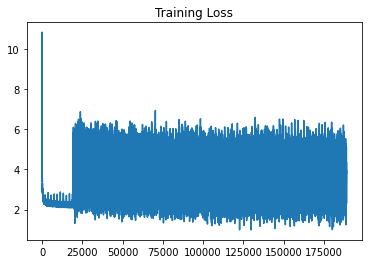

In [5]:
# custom loss
def metric_loss(predicted, y):
    sep = poetry_sy_lm_dataset.vocabulary.word2id("<SEP>")
    go = poetry_sy_lm_dataset.vocabulary.word2id("<GO>")
    eos = poetry_sy_lm_dataset.vocabulary.word2id("<EOS>")
    eov = poetry_sy_lm_dataset.vocabulary.word2id("<EOV>")
    quote = poetry_sy_lm_dataset.vocabulary.word2id("'")
    dquote = poetry_sy_lm_dataset.vocabulary.word2id("\"")
    question = poetry_sy_lm_dataset.vocabulary.word2id("?")
    exclam = poetry_sy_lm_dataset.vocabulary.word2id("!")
    point = poetry_sy_lm_dataset.vocabulary.word2id(".")
    comma = poetry_sy_lm_dataset.vocabulary.word2id(",")
    semicolon = poetry_sy_lm_dataset.vocabulary.word2id(";")

    predicted_cat = tf.squeeze(predicted, 1)
    predicted_cat = tf.random.categorical(predicted_cat, num_samples=1)
    predicted_cat = tf.squeeze(predicted_cat, 1).numpy().tolist()

    def evaluate(seq):
      custom_loss = 0
      splitted = [[]]
      for s in seq:
        if s in [eov]:
          splitted.append([])
          continue
        if s not in [go, sep, eos, 0, point, comma, semicolon, quote, dquote, exclam, question]:
          splitted[-1].append(s)
      verse_counter = 0
      expected_syl = 11
      for line in splitted:
        if verse_counter % 4 == 3: # tercet
          expected_syl = 0
        else:
          expected_syl = 11
        verse_counter += 1
        custom_loss += (len(line) - expected_syl) ** 2
      return custom_loss
      
    return evaluate(predicted_cat) - evaluate(y)

# training
loss_history = []
for epoch in range(n_epochs):
    random.shuffle(batches)
    start = time.time()

    metric_w = 0
    if epoch > 100:
        metric_w = 1

    for b in batches:
        _x, _y = b[0], b[1]
        if len(_y) < batch_size or len(_x) < batch_size:
            print("Discarded batch of length", len(_y))
            continue
        x = to_categorical(_x[:batch_size])
        x = np.expand_dims(x, axis=1)
        y = np.expand_dims(np.asarray(_y[1:batch_size+1]), axis=1)

        with tf.GradientTape() as tape:
            predicted = RNN(x)
            custom_loss = metric_loss(predicted, y)
            cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(y, predicted, from_logits = True)
            current_loss = tf.reduce_mean(cross_entropy) + metric_w*custom_loss/5000

        gradients = tape.gradient(current_loss, RNN.trainable_variables)
        optimizer.apply_gradients(zip(gradients, RNN.trainable_variables))
    
        loss_history.append(current_loss)
    
    print("=========================== Epoch: {}.  \t  Loss: {}  \t  Time: {}ss".format(
        epoch, current_loss.numpy(), round(time.time()-start, 2)))
    
    if epoch % 10 == 9:
        print(generate_text(init, RNN))


plt.plot(loss_history)
plt.title("Training Loss")
plt.show()

RNN.save("/rnn_syll.h5")

references:
-  https://www.groundai.com/project/neural-poetry-learning-to-generate-poems-using-syllables/1
- https://towardsdatascience.com/generating-haiku-with-deep-learning-dbf5d18b4246
- 